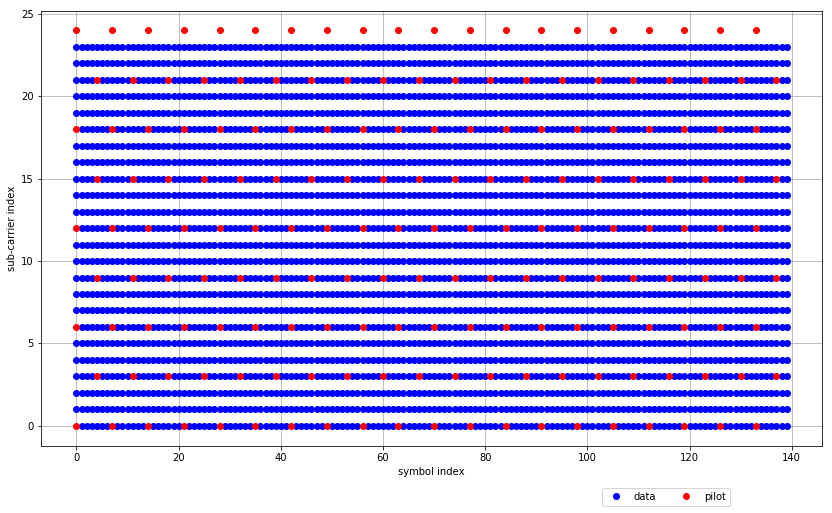

In [89]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import scipy.interpolate

n_carrier = 12  # number of OFDM subcarriers per Physical Resource Block (PRB)
n_symbol = 14  # number of OFDM symbols per PRB
n_RE = n_symbol * n_carrier  # number of Resource Element (RE) per PRB
n_pilot = 8  # number of pilot Resource Element (RE) per PRB

n_PRB = 2  # number of PRB for downlink (DL) and uplink (UL)
n_frame = 10  # number of frames for subcarrier spacing 15 kH
n_RB = n_PRB * n_frame  # number of allocable Resource Blocks (RBs)

CP = 4.69 # [microseconds] length of the cyclic prefix
v_pilot = 3+3j # The known value each pilot transmits

# Reference positions of pilot signals in a PRB
x0_pilot = np.array([0, 0, 4, 4, 7, 7, 11, 11])
y0_pilot = np.array([0, 6, 3, 9, 0, 6,  3,  9])

# Actual positions of pilot signals for the OFDM system
x_pilot = np.zeros(8*n_RB, dtype=int)
y_pilot = np.zeros(8*n_RB, dtype=int)
kk = 0
for ii in range(n_frame):
    for jj in range(n_PRB):
        x_pilot[kk*n_pilot:(kk+1)*n_pilot] = x0_pilot + (ii*n_symbol)
        y_pilot[kk*n_pilot:(kk+1)*n_pilot] = y0_pilot + (jj*n_carrier)
        kk += 1

# For convenience of channel estimation, let's add one pilot carrier from adjacent PRB
x1_pilot = np.arange(0,n_symbol*n_frame,n_symbol/2).astype(int)
y1_pilot = n_carrier*n_PRB*np.ones(2*n_frame).astype(int)

x_pilot = np.hstack((x_pilot, x1_pilot))
y_pilot = np.hstack((y_pilot, y1_pilot))

# Populate the resource element matrix with pilot ('1') and data ('0') symbols 
A0 = np.zeros([n_symbol*n_frame, (n_carrier*n_PRB)+1], dtype=bool)
A0[x_pilot, y_pilot] = 1  # data REs are all remaining REs
x_data, y_data = np.where(A0[:,:-1]==0) # find indexes of data REs

# Plot the figure
ax = plt.subplots(figsize=(14,8))
plt.plot(x_data, y_data, 'bo', label='data')
plt.plot(x_pilot, y_pilot, 'ro', label='pilot')
plt.xlabel('symbol index')
plt.ylabel('sub-carrier index')
plt.grid(True)
plt.legend(loc='lower center', fontsize=10, bbox_to_anchor=(0.8, -0.15), ncol=2)
plt.savefig("pilots.png")

<BarContainer object of 2 artists>

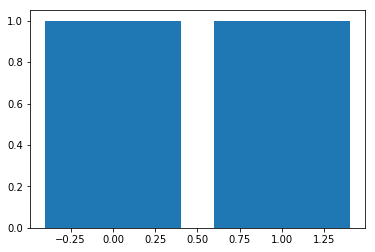

In [28]:
#n_pilot_time_sample
N = 2  *n_frame
pilot_ = np.random.randn(N)
avg_win = np.zeros(N, dtype=int)
pilot_avg = np.zeros(N)
for ii in range(N):
    if ii==0 or ii==N-1:
        avg_win[ii] = 1
        pilot_avg[ii] = pilot_[ii]
    elif ii>=1 and ii<10:
        avg_win[ii] = pilot_[0:2*ii+1].shape[0]
        pilot_avg[ii] = np.average(pilot_[0:2*ii+1])
    elif ii>=N-10 and ii<N-1:
        avg_win[ii] = pilot_[2*ii-N:-1].shape[0]
        pilot_avg[ii] = np.average(pilot_[2*ii-N:-1])
    else:
        avg_win[ii] = pilot_[ii-9:ii+10].shape[0]
        pilot_avg[ii] = np.average(pilot_[ii-9:ii+10])

ax = plt.subplots()
plt.bar(np.arange(N), avg_win)


allCarriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
pilotCarriers: [ 0  3  6  9 12 15 18 21 24]
dataCarriers:  [ 1  2  4  5  7  8 10 11 13 14 16 17 19 20 22 23]


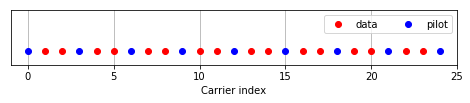

In [90]:
# Plot the average carrier values
K = n_carrier*n_PRB # number of OFDM subcarriers
CP = K//4  # length of the cyclic prefix: 25% of the block
P = (4*n_PRB) # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits

allCarriers = np.arange(K+1)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carrier also be a pilot
#pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P + 1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.figure(figsize=(8,1))
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.legend(fontsize=10, ncol=2)
plt.xlim((-1,K+1))
plt.ylim((-0.1, 0.3))
plt.xlabel('Carrier index')
plt.yticks([])
plt.grid(True);

(0, 24)

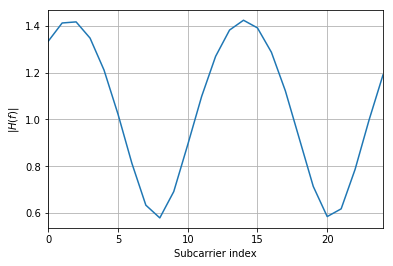

In [91]:
# Plot the channel response
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K+1)

plt.plot(allCarriers, abs(H_exact))
plt.xlabel('Subcarrier index')
plt.ylabel('$|H(f)|$')
plt.grid(True)
plt.xlim(0, K)

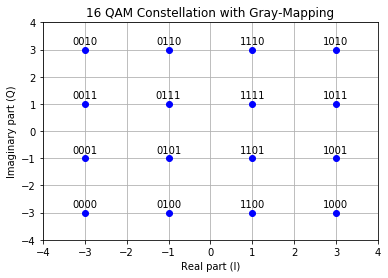

In [31]:
mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
                
demapping_table = {v : k for k, v in mapping_table.items()}

plt.grid(True)
plt.xlim((-4, 4)); plt.ylim((-4,4)); plt.xlabel('Real part (I)'); plt.ylabel('Imaginary part (Q)')
plt.title('16 QAM Constellation with Gray-Mapping');

In [65]:
print(pilotCarriers.size)
print(dataCarriers.size)
K+1

9
16


25

In [86]:
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K+1, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)

def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning

def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR

    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

def removeCP(signal):
    return signal[CP:(CP+K+1)]

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values

    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)

    return Hest

def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

def get_payload(equalized):
    return equalized[dataCarriers]

def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])

    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))

    # for each element in QAM, choose the index in constellation
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)

    # get back the real constellation point
    hardDecision = constellation[const_index]

    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

def PS(bits):
    return bits.reshape((-1,))

Obtained Bit error rate:  0.265625


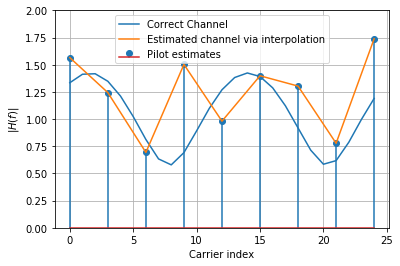

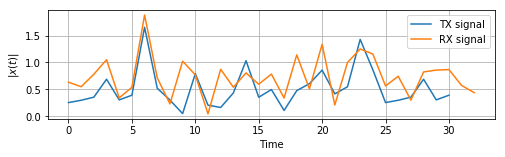

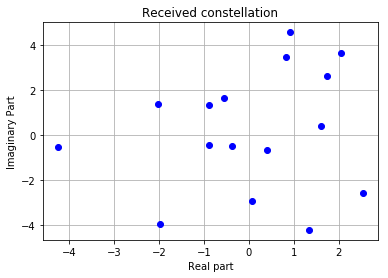

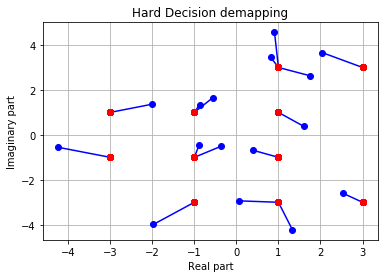

In [92]:
SNRdb = 3  # signal to noise-ratio in dB at the receiver

mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol


bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
bits_SP = SP(bits)
QAM = Mapping(bits_SP)
OFDM_data = OFDM_symbol(QAM)
OFDM_time = IDFT(OFDM_data)
OFDM_withCP = addCP(OFDM_time)
OFDM_TX = OFDM_withCP

OFDM_RX = channel(OFDM_TX)
OFDM_RX_noCP = removeCP(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

plt.figure()
Hest = channelEstimate(OFDM_demod)
plt.savefig("channelEstimate.png")

equalized_Hest = equalize(OFDM_demod, Hest)
QAM_est = get_payload(equalized_Hest)
PS_est, hardDecision = Demapping(QAM_est)
bits_est = PS(PS_est)

plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);
plt.savefig("Time-domainSignals.png")

plt.figure()
plt.plot(QAM_est.real, QAM_est.imag, 'bo');
plt.grid(True); plt.xlabel('Real part'); plt.ylabel('Imaginary Part'); plt.title("Received constellation"); # il
plt.savefig("Constellation.png")

plt.figure()
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')
plt.grid(True); plt.xlabel('Real part'); plt.ylabel('Imaginary part'); plt.title('Hard Decision demapping'); # il
plt.savefig("HardDecision.png")

print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

plt.show()

In [83]:
pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values

# Perform interpolation between the pilot carriers to get an estimate
# of the channel in the data carriers. Here, we interpolate absolute value and phase
# separately
Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
Hest = Hest_abs * np.exp(1j*Hest_phase)


In [22]:
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)

In [23]:
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.0
